In [1]:
import io
import pandas as pd
import numpy as np
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
from torch.backends import cudnn

from PIL import Image
from matplotlib import pyplot as plt
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, monotonically_increasing_id, udf
from pyspark.ml.functions import vector_to_array
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.session import SparkSession
from typing import Iterator
from pyspark.sql.types import *

In [2]:
spark = SparkSession.builder.appName("PysparkTesting")\
    .config("spark.driver.memory", "32g")\
    .getOrCreate()
spark.sparkContext.addPyFile("../fastreid.zip")

In [3]:
# df = spark.read.format("image").option("dropInvalid", True).option("recursiveFileLookup","true").load("/data0/VERI-Wild").limit(100)
df = spark.read.format("image").option("recursiveFileLookup","true").option("dropInvalid", True).load("/data0/veri").limit(100)
df.cache()

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

In [4]:
df.select("image.origin", "image.width", "image.height").show(10, truncate=False)

+------------------------------------------------------------+-----+------+
|origin                                                      |width|height|
+------------------------------------------------------------+-----+------+
|file:///data0/veri/YongtaiPoint_Google.jpg                  |1200 |900   |
|file:///data0/veri/veri/YongtaiPoint_Google.jpg             |1200 |900   |
|file:///data0/veri/veri/image_train/0128_c018_00022240_0.jpg|975  |753   |
|file:///data0/veri/image_train/0128_c018_00022240_0.jpg     |975  |753   |
|file:///data0/veri/veri/image_train/0148_c018_00007085_0.jpg|1169 |809   |
|file:///data0/veri/image_train/0148_c018_00007085_0.jpg     |1169 |809   |
|file:///data0/veri/veri/image_train/0406_c016_00005350_0.jpg|788  |860   |
|file:///data0/veri/image_train/0406_c016_00005350_0.jpg     |788  |860   |
|file:///data0/veri/veri/image_train/0408_c016_00076635_0.jpg|821  |914   |
|file:///data0/veri/image_train/0408_c016_00076635_0.jpg     |821  |914   |
+-----------

In [5]:
from fastreid.data.datasets import VeRiWild
from fastreid.config import get_cfg
from fastreid.modeling.meta_arch import build_model
from fastreid.utils.checkpoint import Checkpointer
from fastreid.data.build import fast_batch_collator
from fastreid.data import samplers
from fastreid.data.transforms import build_transforms

In [6]:
config_file = '../logs/old-veriwild/bagtricks_R50-ibn_4gpu/config.yaml'

opts = ['MODEL.WEIGHTS', '../logs/old-veriwild/bagtricks_R50-ibn_4gpu/model_final.pth']

cfg = get_cfg()
cfg.merge_from_file(config_file)
cfg.merge_from_list(opts)
cfg.freeze()

cudnn.benchmark = True

In [7]:
class OurPredictor:

    def __init__(self, cfg):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.cfg.defrost()
        self.cfg.MODEL.BACKBONE.PRETRAIN = False
        self.model = build_model(self.cfg)
        self.model.eval()

        Checkpointer(self.model).load(cfg.MODEL.WEIGHTS)

    def __call__(self, image):
        """
        Args:
            image (torch.tensor): an image tensor of shape (B, C, H, W).
        Returns:
            predictions (torch.tensor): the output features of the model
        """
        inputs = {"images": image}
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            predictions = self.model(inputs)
#             print(predictions.is_cuda)
#             print(predictions.get_device())
            # Normalize feature to compute cosine distance
            features = F.normalize(predictions)
            features = features.cpu()
            return features
        
def get_loader(dataset, mini_batch_size):
    data_sampler = samplers.InferenceSampler(len(dataset))
    batch_sampler = torch.utils.data.BatchSampler(data_sampler, mini_batch_size, False)
    return DataLoader(
        dataset,
        batch_sampler=batch_sampler,
        num_workers=4,  # save some memory
        collate_fn=fast_batch_collator,
        pin_memory=True,
    )

In [8]:
class OurDataset(Dataset):
    
    def __init__(self, cfg, contents):
        self.cfg = cfg
        self.contents = contents
        self.transform = build_transforms(cfg, is_train=False)

    def __len__(self):
        return len(self.contents)
    
    def _read_image(self, h, w, content):
        img = np.fromstring(content, np.uint8).reshape(h, w, 3)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = cv2.resize(img, tuple(self.cfg.INPUT.SIZE_TEST[::-1]), interpolation=cv2.INTER_CUBIC)
        return Image.fromarray(image)

    def __getitem__(self, index):
        img = self._read_image(*self.contents[index])
        if self.transform is not None: img = self.transform(img)
        return img

In [9]:
@pandas_udf(ArrayType(DoubleType()))
def predict(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    # TODO THIS PREDICTOR USES ONLY 1 GPU, fix this later to use multiple GPUS
    predictor = OurPredictor(cfg)
    for height, width, content_series in content_series_iter:
        dataset = OurDataset(cfg, list(zip(height, width, content_series)))
        loader = get_loader(dataset, 128)
        for image_batch in loader:
            feat_vecs = predictor(image_batch).numpy()
            yield pd.Series(feat_vecs.tolist())


In [10]:
test_preds = df.withColumn("feat_vector", predict(col("image.height"), col("image.width"), col("image.data")))
test_preds.cache()

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>, feat_vector: array<double>]

In [11]:
test_preds.select("image.origin", "feat_vector").show(10)

+--------------------+--------------------+
|              origin|         feat_vector|
+--------------------+--------------------+
|file:///data0/ver...|[0.0, -0.02569053...|
|file:///data0/ver...|[0.0, -0.02569053...|
|file:///data0/ver...|[0.0, 0.022140571...|
|file:///data0/ver...|[0.0, 0.022140571...|
|file:///data0/ver...|[0.0, 0.034763112...|
|file:///data0/ver...|[0.0, 0.034763112...|
|file:///data0/ver...|[0.0, 0.035980869...|
|file:///data0/ver...|[0.0, 0.035980869...|
|file:///data0/ver...|[0.0, -0.01677100...|
|file:///data0/ver...|[0.0, -0.01677100...|
+--------------------+--------------------+
only showing top 10 rows



## Numpy based computation and sanity check of similarity score order

In [12]:
import os
!rm -rf saves original_files
!mkdir saves && mkdir original_files
for row in test_preds.select("image.origin", "feat_vector").collect():
    fn = row['origin'].split(':')[1].split('/')[-1].split('.')[0]
    os.system(f"cp {row['origin'].split(':')[1][2:]} original_files/{fn}.jpg")
    np.save('saves/'+fn+'.npy', row['feat_vector'])

In [13]:
!cd ~/fast-reid && bash demo/run_VERIWild_demo.sh && cd -

[03/10 21:33:43 fastreid.utils.checkpoint]: Loading checkpoint from logs/old-veriwild/bagtricks_R50-ibn_4gpu/model_final.pth
100%|███████████████████████████████████████████| 45/45 [00:01<00:00, 31.78it/s]
/home/kishan/fast-reid/pyspark-testing


In [14]:
_, _, l = next(os.walk('saves'))

In [15]:
need_to_get = []
we_got = []

for k in l:
    org = np.load('from_demosh/'+k).squeeze()
    need_to_get.append(org)
    our = np.load('saves/'+k)
    we_got.append(our)
    # Directly comparing vectors might lead to incomplete conclusions
    # We instead use feature simililarity score based sorting in next cells
#     print(org)
#     print(our)
#     print(np.abs(org - our))
#     print(np.allclose(org, our))

In [16]:
th1 = np.array(need_to_get)

In [17]:
base_sim_mat = np.dot(th1, th1.transpose())

In [18]:
wg1 = np.array(we_got)

In [19]:
our_sim_mat = np.dot(wg1, wg1.transpose())

In [20]:
np.abs(base_sim_mat - our_sim_mat)

array([[1.97807389e-08, 3.97806436e-08, 4.95605201e-09, ...,
        2.75007514e-08, 3.32128161e-08, 1.02645891e-07],
       [3.97806436e-08, 1.33098018e-08, 3.14014424e-08, ...,
        3.45556415e-07, 7.35693562e-08, 1.26556543e-07],
       [4.95605201e-09, 3.14014424e-08, 5.03383730e-08, ...,
        4.14075663e-10, 7.22170485e-08, 9.71220906e-08],
       ...,
       [2.75007514e-08, 3.45556415e-07, 4.14075663e-10, ...,
        2.22548778e-07, 1.63878758e-07, 1.86077872e-07],
       [3.32128161e-08, 7.35693562e-08, 7.22170485e-08, ...,
        1.63878758e-07, 1.03833739e-07, 1.39233938e-07],
       [1.02645891e-07, 1.26556543e-07, 9.71220906e-08, ...,
        1.86077872e-07, 1.39233938e-07, 1.40952354e-07]])

In [21]:
sortth = np.argsort(base_sim_mat, axis=1)
print(sortth)

[[27 35 23 ... 26 12  0]
 [43 13 30 ... 31 41  1]
 [27 23 35 ...  6 32  2]
 ...
 [43 30 21 ... 31 14 42]
 [37 42 40 ... 13 30 43]
 [37 42 40 ... 38 28 44]]


In [22]:
sortour = np.argsort(our_sim_mat, axis=1)
print(sortour)

[[27 35 23 ... 26 12  0]
 [43 13 30 ... 31 41  1]
 [27 23 35 ...  6 32  2]
 ...
 [43 30 21 ... 31 14 42]
 [37 42 40 ... 13 30 43]
 [37 42 40 ... 38 28 44]]


In [23]:
sortour == sortth

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [24]:
np.sum(sortour == sortth), np.sum(sortour != sortth)

(2025, 0)

In [25]:
45*45

2025

## Spark based vector to dataframe cosine similarity

In [26]:
square_udf_float = udf(lambda z: square(z), FloatType())

def get_cosinesim_df(ref_vec):
    def np_cosine(row):
        a, b = np.array(row), np.array(ref_vec)
        return float(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))
    cosine_udf = udf(np_cosine, FloatType())
    return test_preds.select("image.origin", cosine_udf("feat_vector").alias("cosine_sim"))

In [27]:
wg1[0], wg1[0].shape

(array([ 0.        ,  0.00302133,  0.01317512, ...,  0.        ,
         0.        , -0.04348269]),
 (2048,))

> Change input vector to this next function call to query on different images. Use this to observe different plots

In [28]:
# sim_df = get_cosinesim_df(list(wg1[0]))
sim_df = get_cosinesim_df(list(wg1[40]))
# sim_df = get_cosinesim_df(list(wg1[29]))

In [29]:
sim_df.dtypes

[('origin', 'string'), ('cosine_sim', 'float')]

In [30]:
sim_scores_pd = sim_df.toPandas()

In [31]:
sim_scores_pd['origin'] = sim_scores_pd['origin'].apply(lambda x: x.split(':')[1][2:]) # Fix string format of origin
sim_scores_pd.head()

,origin,cosine_sim
0,/data0/veri/YongtaiPoint_Google.jpg,0.325593
1,/data0/veri/veri/YongtaiPoint_Google.jpg,0.325593
2,/data0/veri/veri/image_train/0128_c018_0002224...,0.132404
3,/data0/veri/image_train/0128_c018_00022240_0.jpg,0.132404
4,/data0/veri/veri/image_train/0148_c018_0000708...,0.126478


In [32]:
sim_scores_pd.sort_values(by=['cosine_sim'], ascending=False, inplace=True)
print(sim_scores_pd)

                                               origin  cosine_sim
48  /data0/veri/veri/image_train/0278_c008_0003036...    1.000000
49   /data0/veri/image_train/0278_c008_00030365_0.jpg    1.000000
74  /data0/veri/veri/image_train/0278_c004_0003051...    0.418755
75   /data0/veri/image_train/0278_c004_00030515_0.jpg    0.418755
89   /data0/veri/image_train/0269_c007_00063510_0.jpg    0.405860
..                                                ...         ...
28  /data0/veri/veri/image_train/0128_c018_0002225...    0.092316
21   /data0/veri/image_train/0148_c018_00007110_0.jpg    0.078055
20  /data0/veri/veri/image_train/0148_c018_0000711...    0.078055
42  /data0/veri/veri/image_train/0148_c018_0000712...    0.075941
43   /data0/veri/image_train/0148_c018_00007120_0.jpg    0.075941

[100 rows x 2 columns]


In [33]:
img_list = []
for row in sim_scores_pd.head(30).itertuples():
    img_list.append((row.origin, row.cosine_sim))

In [34]:
def image_grid(img_list, rows, columns, fig_size=(15, 15)):
    imgs = [(Image.open(i), score) for i,score in img_list]
    assert len(imgs) == rows*columns
    fig=plt.figure(figsize=fig_size)
    for i in range(1, columns*rows +1):
        img = imgs[i-1][0]
        ax = fig.add_subplot(rows, columns, i)
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.5,-0.1, f"score {imgs[i-1][1]:.3f}", size=12, ha="center", 
         transform=ax.transAxes)
    plt.show()

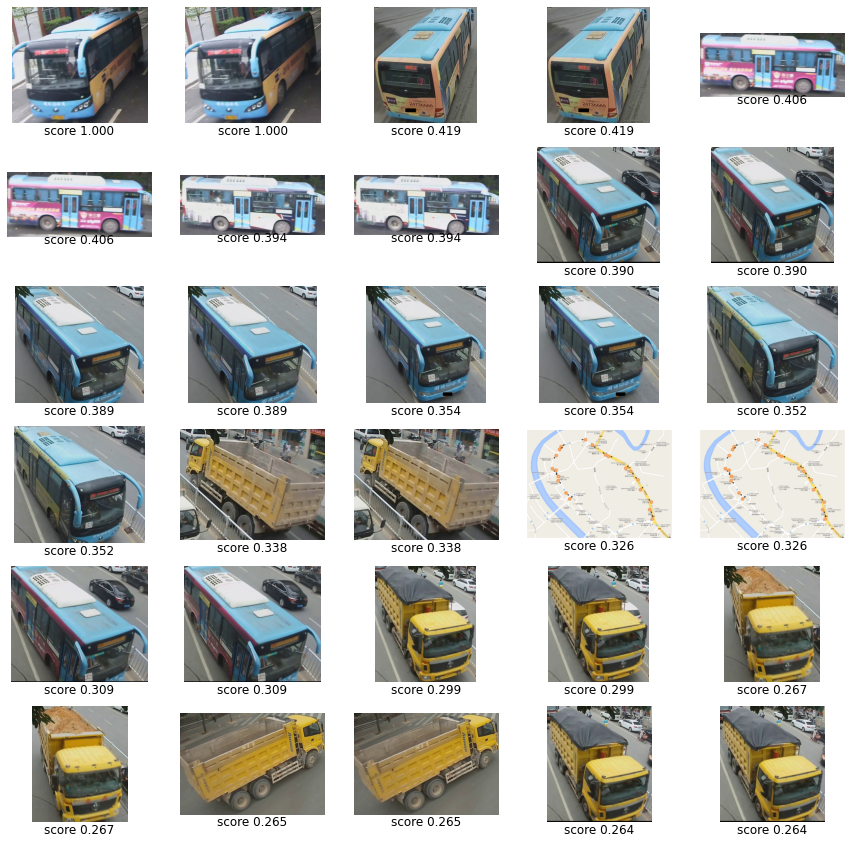

In [35]:
image_grid(img_list, rows=6, columns=5)

In [36]:
img_list = []
for row in sim_scores_pd.tail(30).itertuples():
    img_list.append((row.origin, row.cosine_sim))

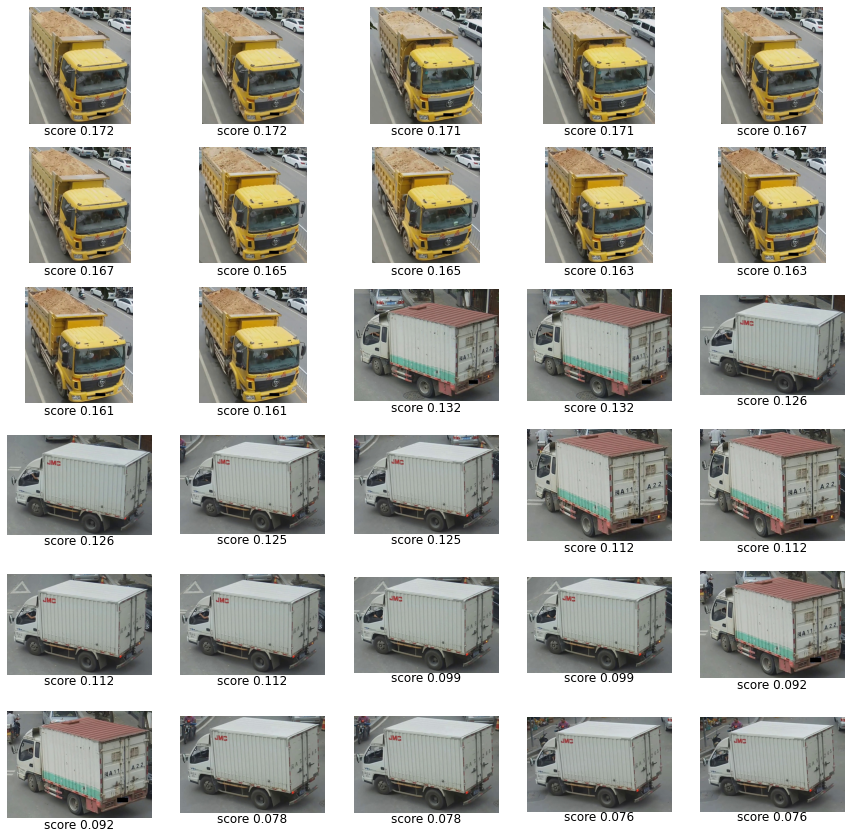

In [37]:
image_grid(img_list, rows=6, columns=5)